## Impoting libaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
import json
import isodate

## Building a YouTube api request object

In [2]:
from apiclient.discovery import build
def build_api_request():
    key = json.load(open(".secret/api_key.json"))['api_key']
    return build("youtube", "v3", developerKey=key)

In [3]:
youtube = build_api_request()

## Searching for the top n channels for a topic

In [4]:
def top_n_channels(topic_id, n):
    req = youtube.search().list(topicId = topic_id, part = 'snippet', type = 'channel',
                                order = 'viewCount', maxResults = n).execute()
    channel_ids = [channel['id']['channelId'] for channel in req['items']]
    req = youtube.channels().list(part = "snippet,statistics", id = ', '.join(channel_ids)).execute()
    channels = []
    for channel in req['items']:
        channels.append({'channel_name': channel['snippet']['title'], 
                         'channel_id': channel['id'],
                         'video_count': int(channel['statistics']['videoCount']),
                         'subscriber_count': int(channel['statistics']['subscriberCount'])})
    channels_df = pd.DataFrame.from_dict(channels)
    return channels_df.sort_values(by = 'subscriber_count', ascending=False)

## Requesting all videos for a channel

In [5]:
def get_channel_videos(channel_id):
    res = youtube.channels().list(id = channel_id, part = 'contentDetails').execute()
    playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    next_page_token = None
    videos = []
    while True:
        res = youtube.playlistItems().list(playlistId = playlist_id, 
                                           part = 'snippet', 
                                           maxResults = 50,
                                           pageToken = next_page_token).execute()
        video_ids = [x['snippet']['resourceId']['videoId'] for x in res['items']]
        next_page_token = res.get('nextPageToken')
        res = youtube.videos().list(id = ', '.join(video_ids), 
                                    part = 'snippet,contentDetails,statistics').execute()
        videos += res['items']
        if next_page_token is None:
            break
    return videos

## Converting an api request into a dataframe

In [6]:
def get_video_attributes(videos):
    video_list = []
    for video in videos:
        video_list.append({'title': video['snippet']['title'],
                           'description': video.get('snippet', {}).get('description'), 
                           'publish_time': video.get('snippet', {}).get('publishedAt'),
                           'tags': video.get('snippet', {}).get('tags'),
                           'duration': video.get('contentDetails', {}).get('duration'),
                           'like_count': video.get('statistics', {}).get('likeCount'),
                           'dislike_count': video.get('statistics', {}).get('dislikeCount'),
                           'comment_count': video.get('statistics', {}).get('commentCount'),
                           'live': video.get('snippet', {}).get('liveBroadcastContent'),
                           'view_count': video.get('statistics', {}).get('viewCount')})
    return pd.DataFrame.from_dict(video_list)

## Transforming the dataframe for regression model

In [7]:
def transform_video_attributes(df):
    df.dropna(inplace=True)
    df['duration'] = pd.to_datetime(df['duration'].map(lambda x: isodate.parse_duration(x))).map(lambda x: x.minute).astype('int')
    df['publish_time'] = pd.to_datetime(df['publish_time'])
    time_split = pd.DataFrame(df['publish_time'].map(lambda x: [x.hour, x.weekday(), x.month, x.date()]).to_list(), 
                              columns = ['publish_hour', 'publish_day', 'publish_month', 'publish_date'])
    df = pd.concat([df, time_split], axis = 1)
    df.dropna(inplace=True)
    df['publish_date'] = pd.to_datetime(df['publish_date'])
    df.sort_values(by = 'publish_date', inplace = True)
    df['days_after_last_video'] = df['publish_date'].diff(periods = 1)
    df.dropna(inplace=True)
    df['days_after_last_video'] = df['days_after_last_video'].map(lambda x: x.days).astype('int')
    for col in ['duration', 'publish_hour', 'publish_day', 'publish_month', 'comment_count', 'like_count', 'dislike_count', 'view_count']:
        df[col] = df[col].astype('int')
    df[['title_length', 'description_length', 'tag_count']] = df[['title', 'description', 'tags']].applymap(len)
    df['live'] = df['live'].map(lambda x: 0 if 'none' else 1) 
    df.drop(columns = ['description', 'publish_time'], inplace = True)
    return df

## Creating a complete dataframe from the channel id

In [8]:
def create_channel_df(channel_id):
    videos = get_channel_videos(channel_id)
    df = get_video_attributes(videos)
    transformed_df = transform_video_attributes(df)
    return transformed_df

## Creating a dictionary of topics

In [9]:
topic_ids = {'football': '/m/02vx4', 'boxing': '/m/01cgz', 
             'food': '/m/02wbm', 'fitness': '/m/027x7n', 
             'tech': '/m/07c1v', 'gaming': '/m/0bzvm2' }

## Searching for top 25 tech channels

In [10]:
tech_channels = top_n_channels(topic_ids['tech'], 25)
tech_channels.head()

,channel_id,channel_name,subscriber_count,video_count
24,UCsTcErHg8oDvUnTzoqsYeNw,Unbox Therapy,15800000,1708
19,UCE_M8A5yxnLfW0KghEeajjw,Apple,10400000,301
10,UCBJycsmduvYEL83R_U4JriQ,Marques Brownlee,9790000,1169
15,UCK8sQmJBp8GCxrOtXWBpyEA,Google,8240000,2330
1,UCMDQxm7cUx3yXkfeHa5zJIQ,TeamYouTube [Help],7570000,116


## Creating a dataframe for all videos posted by Marques Brownlee

In [11]:
tech_channel_id = tech_channels.loc[12]['channel_id']
tech_channel_df = create_channel_df(tech_channel_id)

/Users/jacktann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  after removing the cwd from sys.path.


In [13]:
tech_channel_df.set_index('publish_date', inplace = True)

In [36]:
tech_channel_df.head(3)

,comment_count,dislike_count,duration,like_count,live,tags,title,view_count,publish_hour,publish_day,publish_month,days_after_last_video,title_length,description_length,tag_count
publish_date,,,,,,,,,,,,,,,
2007-01-08,162,13,2,379,0,"[analisis, a fondo, VS, en español, hands, gad...",videorama blackberry pearl 8100 VS 8800,56646,10,0,1,10,39,69,22
2007-01-16,4037,385,4,12028,0,"[Nokia, videorama, prueba, a fondo, opiniones,...",videorama Nokia 5700 xpress music,525222,20,1,1,8,33,68,21
2007-01-17,25,7,4,94,0,"[en profundidad, opinion, english, a fondo, re...",videorama Nokia 5700 xpress music english version,26678,0,2,1,1,49,68,23


In [38]:
tech_channel_monthly_views = tech_channel_df['2012-01-01':].view_count.resample('MS').mean().astype('int')
tech_channel_monthly_views.head()

publish_date
2012-01-01     49002
2012-02-01    115828
2012-03-01     69416
2012-04-01    113778
2012-05-01     37618
Freq: MS, Name: view_count, dtype: int64

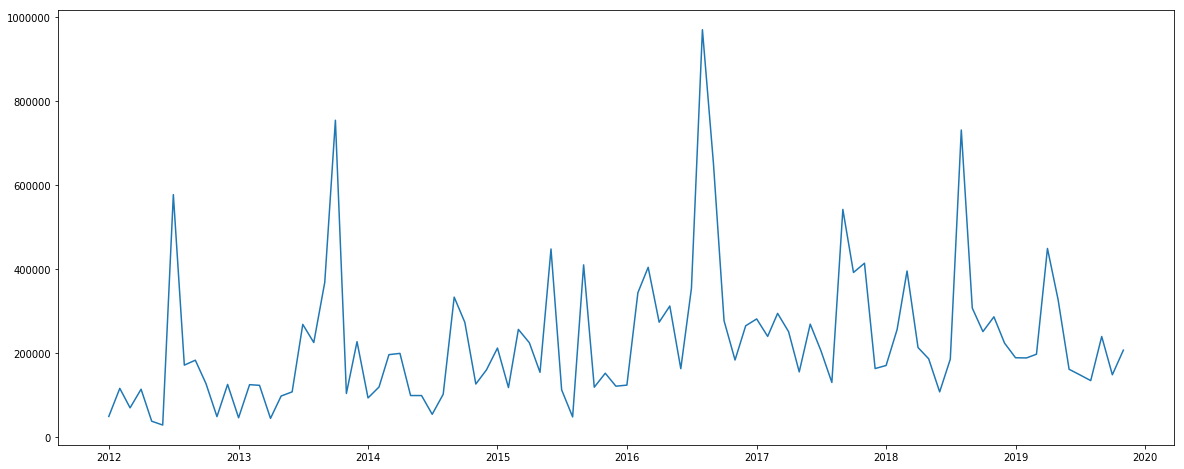

In [39]:
fig = plt.figure(figsize=(20,8))
plt.plot(tech_channel_monthly_views);

In [34]:
words = []
for video in tech_channel_df.title:
    words += video.split(' ')
word_freq_df = pd.DataFrame(pd.Series(words).value_counts()).reset_index()
word_freq_df.columns = ['word', 'frequency']
word_freq_df.head(25)

,word,frequency
0,en,402
1,unboxing,366
2,review,348
3,español,346
4,preview,226
5,Videorama,218
6,y,185
7,#Videorama,134
8,de,130
9,4K,129
